## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Neural Networks notebook (lab 6).
4. The deadline for **both** is **Friday, 17 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

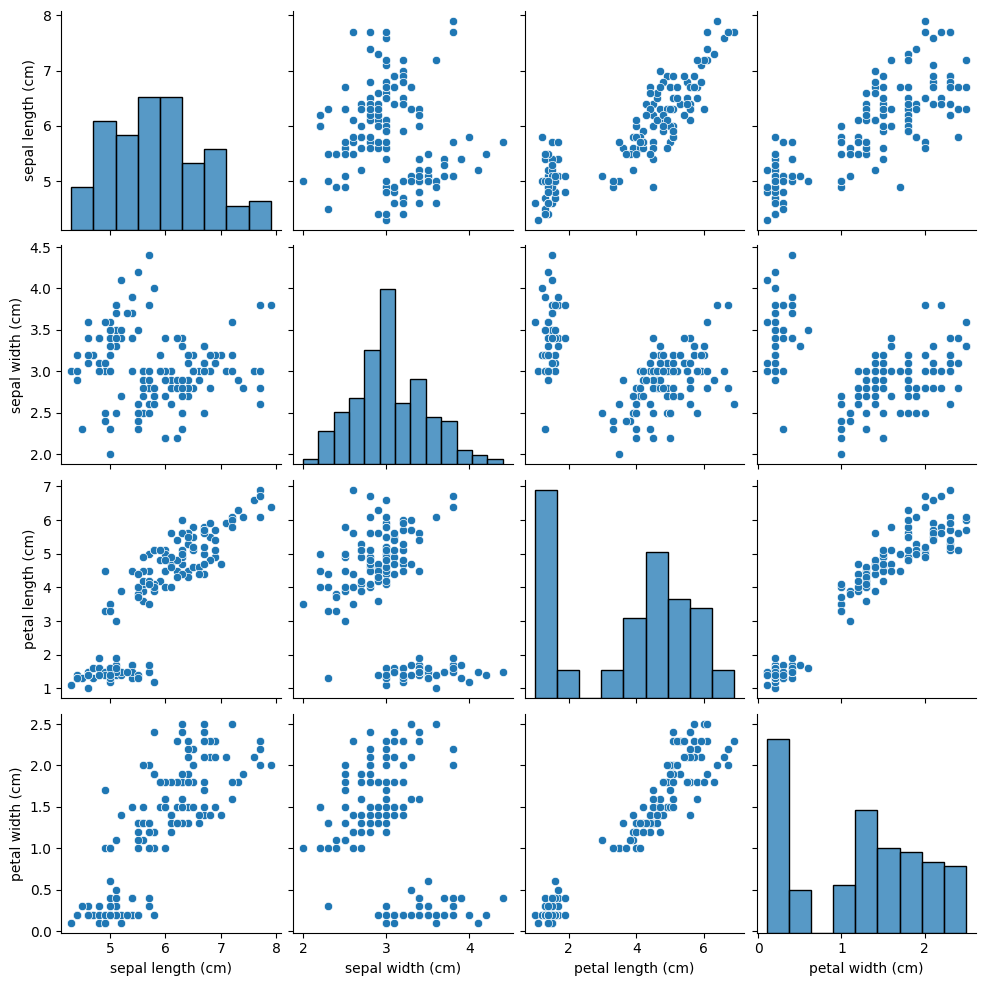

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [3]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="maroon"><u>**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font></u>

In [5]:
### your code here
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  return (x - mu) / sigma

### your code here
# Calculating mean and standard deviation
x_train_mu = torch.mean(x_train, dim=0)
x_train_std = torch.std(x_train, dim=0)

# Getting normalised versions of datasets
x_train_norm = norm_set(x_train, x_train_mu, x_train_std)
x_test_norm = norm_set(x_test, x_train_mu, x_train_std)

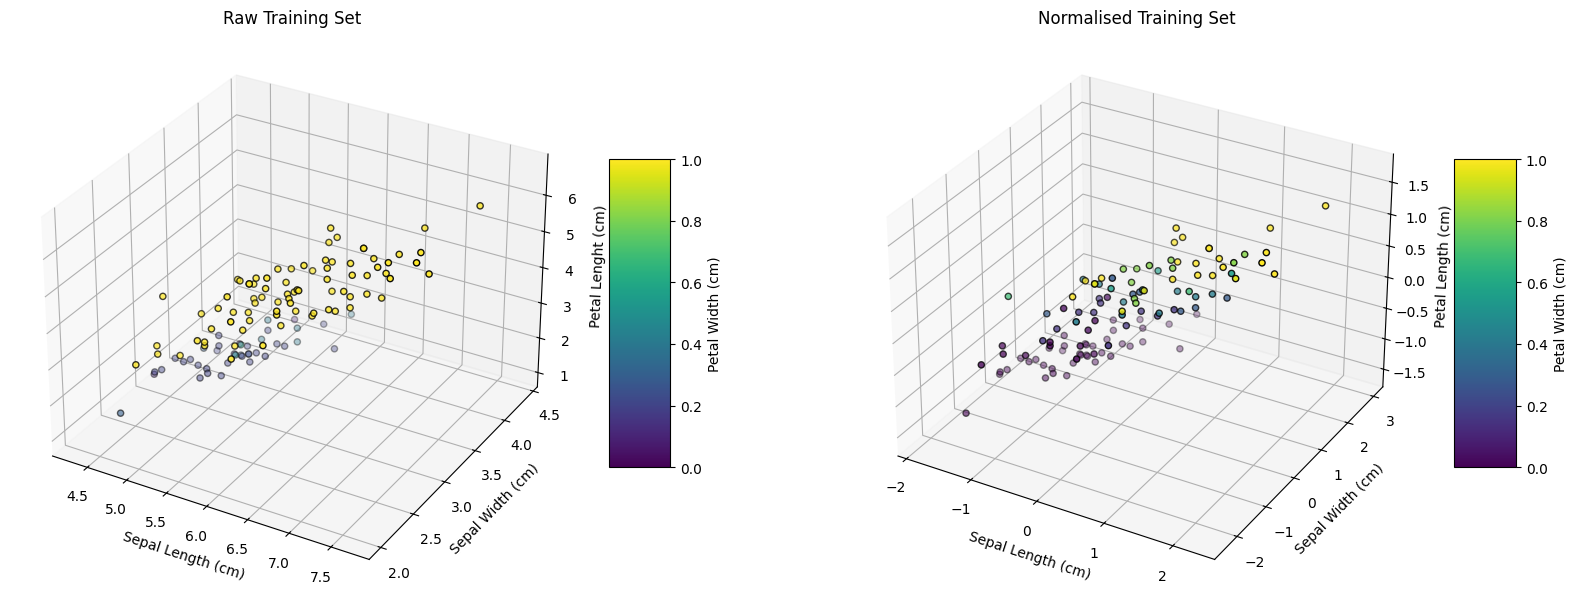

In [6]:
# Plotting normalised and raw training sets
cmap = plt.cm.viridis

# Create the figure and 3D axis
fig = plt.figure(figsize=(20, 8))

# Add a 3D subplot for the training data
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], c=cmap(x_train[:, 3]), edgecolor='k')
ax1.set_title('Raw Training Set')
ax1.set_xlabel('Sepal Length (cm)')
ax1.set_ylabel('Sepal Width (cm)')
ax1.set_zlabel('Petal Lenght (cm)')
# Add a color bar which maps values to colors
cbar = fig.colorbar(sc1, ax=ax1, shrink=0.5, aspect=5)
cbar.set_label('Petal Width (cm)')

# Add a 3D subplot for the test data
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(x_train_norm[:, 0], x_train_norm[:, 1], x_train_norm[:, 2], c=cmap(x_train_norm[:, 3]), edgecolor='k')
ax2.set_title('Normalised Training Set')
ax2.set_xlabel('Sepal Length (cm)')
ax2.set_ylabel('Sepal Width (cm)')
ax2.set_zlabel('Petal Length (cm)')
# Add a color bar which maps values to colors
cbar = fig.colorbar(sc2, ax=ax2, shrink=0.5, aspect=5)
cbar.set_label('Petal Width (cm)')

# Show the plot
plt.show()

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

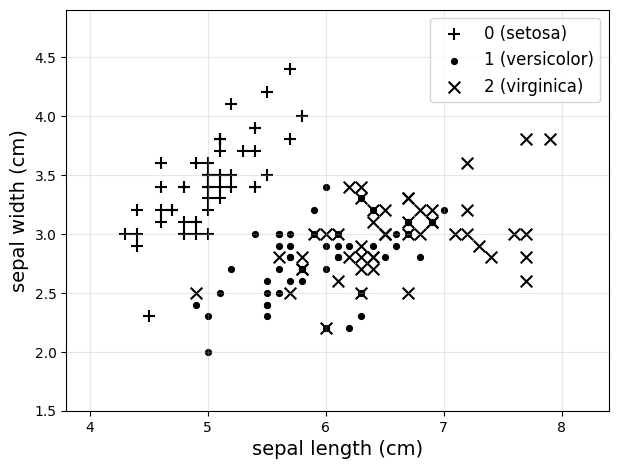

In [7]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
x_train = x_train_norm
x_test = x_test_norm

In [9]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

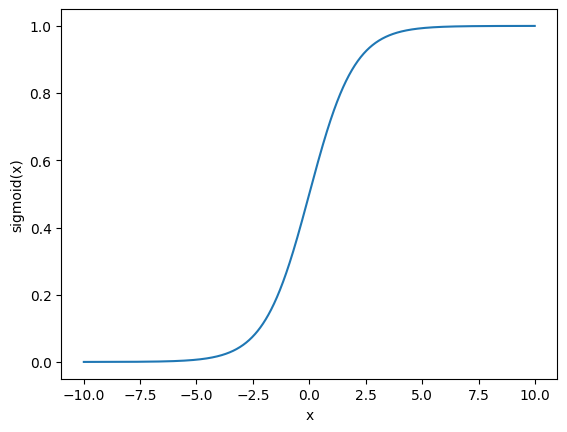

In [10]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  return 1 / (1 + torch.exp(-z))


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [11]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    y = torch.matmul(x, self.weight.t())
    return sigmoid(y)

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [12]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    ### your code here
    m = y_pred.shape[0]
    return 1/m * torch.sum(-y_true * np.log(y_pred) - (1-y_true) * np.log(1-y_pred))

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  dw = torch.sum((y_pred - y) * X)
  model.weight = nn.Parameter(weight - lr * dw, requires_grad=False)

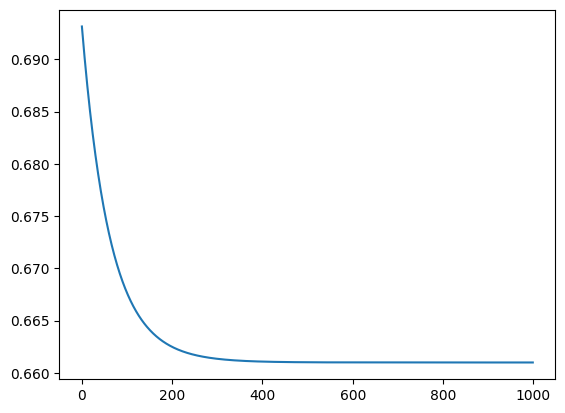

Parameter containing:
tensor([[-0.3182, -0.3182, -0.3182]])
Minimum cost: 0.66098552942276


In [13]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.0001 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

<u><font color="maroon"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font></u>

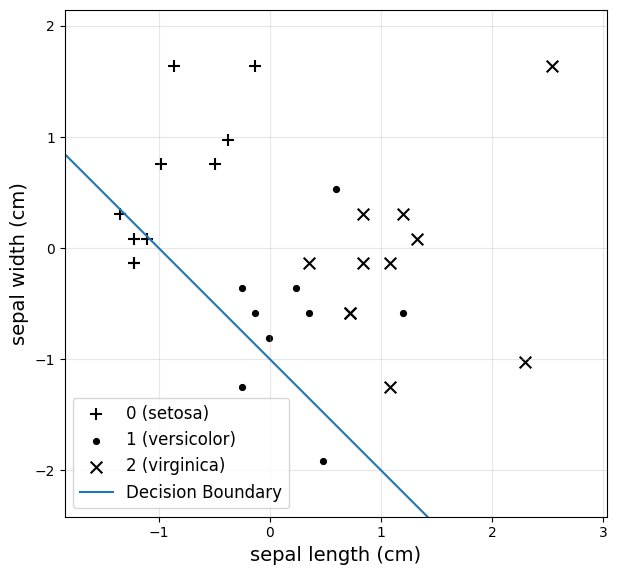

In [14]:
### your code here (code has been adapted from code block [7])
X = x_test[:, :2]
Y = y_test

x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

params = model.weight.flatten()

x1 = [x1_min, x1_max]
x2 = (-params[0] - np.dot(params[1], x1)) / params[2]

marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X[(Y == l).nonzero()[:, 0], 0],
      X[(Y == l).nonzero()[:, 0], 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

plt.plot(x1, x2, label='Decision Boundary')
ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
plt.show()

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [15]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [16]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


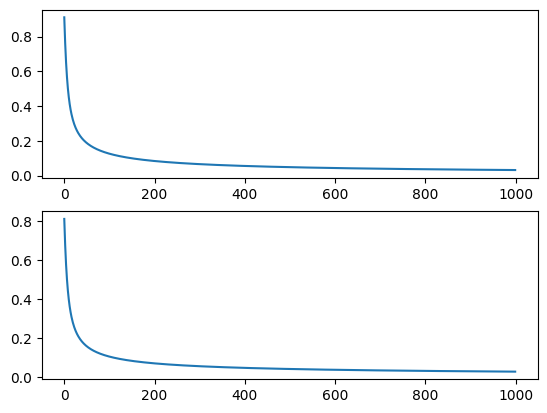

Minimum train cost: 0.03149240091443062
Minimum test cost: 0.02744917757809162


In [17]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

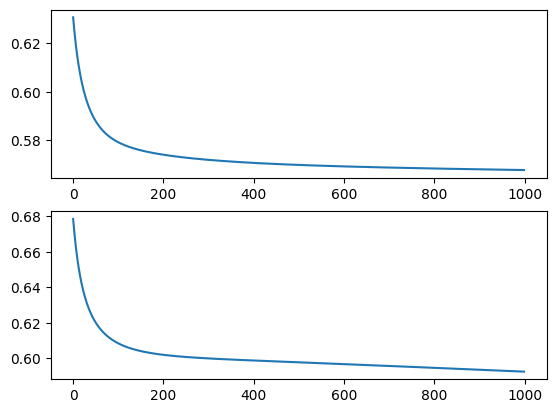

Minimum train cost: 0.567813515663147
Minimum test cost: 0.5925337076187134


In [18]:
### your code here

# Versicolor
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolor_model.parameters(), alpha)

train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser, alpha)

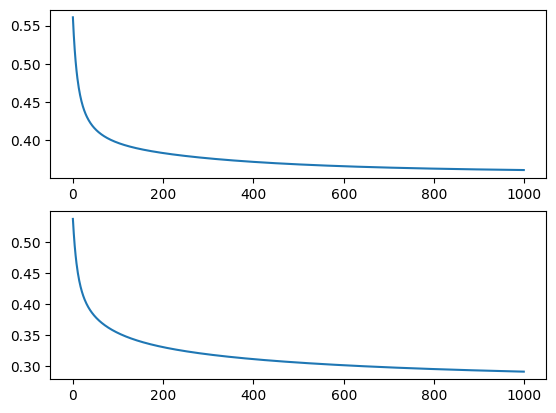

Minimum train cost: 0.36034834384918213
Minimum test cost: 0.2915734052658081


In [19]:
# Virginica
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(virginica_model.parameters(), alpha)

train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, optimiser, alpha)

<u><font color="maroon"> **Q6.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font></u>

In [20]:
### your code here
classes = ["Setosa", "Versicolor", "Virginica"]

data = {
    "Sepal Length": x_test[:, 0],
    "Sepal Width": x_test[:, 1],
    "Petal Length": x_test[:, 2],
    "Petal Width": x_test[:, 3],
    "Setosa Classifier": setosa_model(x_test).detach().numpy()[:, 0],
    "Versicolor Classifier": versicolor_model(x_test).detach().numpy()[:, 0],
    "Virginica Classifier": virginica_model(x_test).detach().numpy()[:, 0],
    "Actual Class": [classes[list(v).index(max(v))] for v in y_test]
}
table = pd.DataFrame(data=data)
table["Predicted Class"] = [
    classes[(a,b,c).index(max(a,b,c))]
    for a,b,c in zip(table.iloc[:,-4], table.iloc[:,-3], table.iloc[:,-2])
]
table

,Sepal Length,Sepal Width,Petal Length,Petal Width,Setosa Classifier,Versicolor Classifier,Virginica Classifier,Actual Class,Predicted Class
0,0.353037,-0.582617,0.555446,0.022155,0.032316,0.740480,0.449483,Versicolor,Versicolor
1,-0.132515,1.643944,-1.156546,-1.174194,0.999959,0.171854,0.107753,Setosa,Setosa
2,2.295244,-1.027930,1.810907,1.484359,0.000004,0.841488,0.945586,Virginica,Virginica
3,0.231649,-0.359961,0.441313,0.420938,0.038315,0.589581,0.707481,Versicolor,Virginica
4,1.202753,-0.582617,0.612513,0.288010,0.008773,0.769026,0.524390,Versicolor,Versicolor
5,-0.496679,0.753320,-1.270679,-1.041267,0.999684,0.319322,0.079810,Setosa,Setosa
6,-0.253903,-0.359961,-0.072284,0.155082,0.293704,0.548809,0.532521,Versicolor,Versicolor
7,1.324141,0.085351,0.783712,1.484359,0.002480,0.382976,0.970355,Virginica,Virginica
8,0.474425,-1.918554,0.441313,0.420938,0.000551,0.917217,0.382865,Versicolor,Versicolor
9,-0.011127,-0.805273,0.098915,0.022155,0.080498,0.734358,0.370743,Versicolor,Versicolor


<u><font color="maroon"> **Q7.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font></u>

In [21]:
accuracy = np.mean(table["Actual Class"] == table["Predicted Class"])
print(f"Accuracy = {accuracy * 100} %")

Accuracy = 90.0 %


In [22]:
x_train.shape

torch.Size([120, 4])

## 3. The XOR problem

<u><font color="maroon"> **Q8.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font></u>

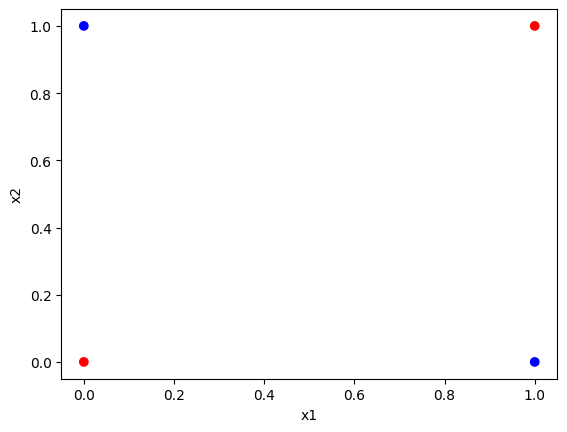

In [23]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()